# 矩形连接器算法实现

本笔记本实现了一个算法，用于解决在网格中连接不同单元格的问题。具体规则见README.md。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# 创建一个单元格，确保核心变量和函数定义在前
# 这个单元格应该放在所有其他代码之前执行

# 全局变量定义
path_usage = {}  # 格式: {(x, y, direction): connection_index}

def reset_path_usage():
    """重置路径占用表"""
    global path_usage
    path_usage = {}

def calculate_path_length(path):
    """计算路径总长度"""
    if path is None:
        return float('inf')
    length = 0
    for i in range(len(path) - 1):
        dx = path[i+1][0] - path[i][0]
        dy = path[i+1][1] - path[i][1]
        length += (dx**2 + dy**2)**0.5
    return length

def find_manhattan_path(start_point, end_point, start_dir, end_dir, start_row, start_col, end_row, end_col):
    """
    找到一条曼哈顿路径（最多两个拐点）
    并确保路径不穿越任何矩形
    """
    # 获取起点和终点坐标
    x1, y1 = start_point
    x2, y2 = end_point
    
    # 创建路径点列表
    path_points = [start_point]
    
    # 根据方向确定是应该先水平后垂直，还是先垂直后水平
    if start_row == end_row:  # 同行
        path_points.append(end_point)
    elif start_col == end_col:  # 同列
        path_points.append(end_point)
    else:  # 需要两次转弯
        # 寻找一条不穿越任何矩形的路径
        # 策略1: 先水平后垂直
        horizontal_first = True
        for r in range(min(start_row, end_row), max(start_row, end_row) + 1):
            for c in range(min(start_col, end_col), max(start_col, end_col) + 1):
                if r != start_row and c != start_col and r != end_row and c != end_col:
                    # 检查会不会穿越这个矩形
                    if (start_col < c < end_col or end_col < c < start_col) and (start_row < r < end_row or end_row < r < start_row):
                        horizontal_first = False
                        break
        
        if horizontal_first:
            # 先水平移动后垂直移动
            mid_point = (x2, y1)
        else:
            # 先垂直移动后水平移动
            mid_point = (x1, y2)
        
        path_points.append(mid_point)
        path_points.append(end_point)
    
    return path_points

print("已加载核心函数和变量")

已加载核心函数和变量


In [3]:
# 定义一个函数来获取单元格的rectangle信息
def get_cell_rect(row, col):
    """
    根据行列获取单元格的rectangle信息
    单元格大小: 50x50像素
    间隙大小: 30像素
    返回: {top, left, right, bottom}
    """
    left = col * (50 + 30)
    top = row * (50 + 30)
    right = left + 50
    bottom = top + 50
    return {"top": top, "left": left, "right": right, "bottom": bottom}

In [4]:
# 计算单元格中心点坐标
def get_cell_center(row, col):
    rect = get_cell_rect(row, col)
    return (rect["left"] + 25, rect["top"] + 25)

In [5]:
# 计算连线坐标
def calculate_connection_points(start_row, start_col, end_row, end_col, connection_index=0):
    """
    根据起始和终点单元格坐标，计算连线的折点坐标
    连线从矩形边框的中点开始和结束，并且不穿越无关矩形
    connection_index: 连线的索引，用于标识不同连线
    """
    start_rect = get_cell_rect(start_row, start_col)
    end_rect = get_cell_rect(end_row, end_col)
    
    # 计算边框中点坐标
    start_top_mid = (start_rect["left"] + 25, start_rect["top"])
    start_bottom_mid = (start_rect["left"] + 25, start_rect["bottom"])
    start_left_mid = (start_rect["left"], start_rect["top"] + 25)
    start_right_mid = (start_rect["right"], start_rect["top"] + 25)
    
    end_top_mid = (end_rect["left"] + 25, end_rect["top"])
    end_bottom_mid = (end_rect["left"] + 25, end_rect["bottom"])
    end_left_mid = (end_rect["left"], end_rect["top"] + 25)
    end_right_mid = (end_rect["right"], end_rect["top"] + 25)
    
    # 确定可能的起点和终点
    start_points = []
    end_points = []
    
    # 根据相对位置确定最合适的起点和终点
    if end_row < start_row:  # 终点在上方
        start_points.append((start_top_mid, "top"))
    elif end_row > start_row:  # 终点在下方
        start_points.append((start_bottom_mid, "bottom"))
    
    if end_col < start_col:  # 终点在左侧
        start_points.append((start_left_mid, "left"))
    elif end_col > start_col:  # 终点在右侧
        start_points.append((start_right_mid, "right"))
    
    # 如果是同行或同列，只添加相应的方向
    if start_row == end_row:
        if end_col < start_col:  # 终点在左侧
            start_points = [(start_left_mid, "left")]
            end_points = [(end_right_mid, "right")]
        else:  # 终点在右侧
            start_points = [(start_right_mid, "right")]
            end_points = [(end_left_mid, "left")]
    elif start_col == end_col:
        if end_row < start_row:  # 终点在上方
            start_points = [(start_top_mid, "top")]
            end_points = [(end_bottom_mid, "bottom")]
        else:  # 终点在下方
            start_points = [(start_bottom_mid, "bottom")]
            end_points = [(end_top_mid, "top")]
    else:
        # 终点可能的连接点 - 修正逻辑，按照终点相对起点的方向
        if start_row < end_row:  # 起点在上方，终点在下方
            end_points.append((end_bottom_mid, "bottom"))
        else:  # 起点在下方，终点在上方
            end_points.append((end_top_mid, "top"))
        
        if start_col < end_col:  # 起点在左侧，终点在右侧
            end_points.append((end_right_mid, "right"))
        else:  # 起点在右侧，终点在左侧
            end_points.append((end_left_mid, "left"))
    
    # 使用路径寻找算法找到不穿越任何矩形的路径
    return find_non_overlapping_path(start_points, end_points, start_row, start_col, end_row, end_col, connection_index)

In [6]:
def find_non_overlapping_path(start_points, end_points, start_row, start_col, end_row, end_col, connection_index):
    """
    寻找不与其他路径重叠的路径
    """
    best_path = None
    min_path_length = float('inf')
    
    for start_point, start_dir in start_points:
        for end_point, end_dir in end_points:
            # 尝试使用曼哈顿路径（可能有多个转弯点）
            path = find_path_without_overlap(start_point, end_point, start_dir, end_dir, 
                                           start_row, start_col, end_row, end_col, connection_index)
            
            if path:
                # 计算路径长度
                path_length = calculate_path_length(path)
                
                if path_length < min_path_length:
                    min_path_length = path_length
                    best_path = path
    
    # 如果找不到不重叠的路径，尝试更复杂的绕行路径
    if best_path is None:
        for start_point, start_dir in start_points:
            for end_point, end_dir in end_points:
                path = find_complex_path(start_point, end_point, start_dir, end_dir,
                                       start_row, start_col, end_row, end_col, connection_index)
                
                if path:
                    path_length = calculate_path_length(path)
                    
                    if path_length < min_path_length:
                        min_path_length = path_length
                        best_path = path
    
    return best_path

In [7]:
def is_path_segment_free(start, end, direction, connection_index):
    """
    检查路径段是否已被其他连线占用
    start, end: 路径段的起点和终点
    direction: "h" 表示水平段, "v" 表示垂直段
    """
    global path_usage
    
    if direction == "h":
        x_min, x_max = min(start[0], end[0]), max(start[0], end[0])
        y = start[1]  # 水平线段y坐标相同
        
        for x in range(int(x_min), int(x_max) + 1):
            key = (x, y, "h")
            if key in path_usage and path_usage[key] != connection_index:
                return False
    else:  # direction == "v"
        y_min, y_max = min(start[1], end[1]), max(start[1], end[1])
        x = start[0]  # 垂直线段x坐标相同
        
        for y in range(int(y_min), int(y_max) + 1):
            key = (x, y, "v")
            if key in path_usage and path_usage[key] != connection_index:
                return False
    
    return True

In [8]:
def mark_path_as_used(path, connection_index):
    """
    将路径标记为已使用
    """
    global path_usage
    
    for i in range(len(path) - 1):
        start, end = path[i], path[i+1]
        
        # 判断方向
        if start[0] == end[0]:  # 垂直线段
            y_min, y_max = min(start[1], end[1]), max(start[1], end[1])
            x = start[0]
            
            for y in range(int(y_min), int(y_max) + 1):
                path_usage[(x, y, "v")] = connection_index
        else:  # 水平线段
            x_min, x_max = min(start[0], end[0]), max(start[0], end[0])
            y = start[1]
            
            for x in range(int(x_min), int(x_max) + 1):
                path_usage[(x, y, "h")] = connection_index

In [9]:
def find_path_without_overlap(start_point, end_point, start_dir, end_dir, start_row, start_col, end_row, end_col, connection_index):
    """
    寻找不与其他路径重叠的曼哈顿路径
    """
    # 尝试标准的曼哈顿路径（最多两个拐点）
    path = find_manhattan_path(start_point, end_point, start_dir, end_dir, start_row, start_col, end_row, end_col)
    
    # 检查路径是否与其他路径重叠
    for i in range(len(path) - 1):
        start, end = path[i], path[i+1]
        direction = "h" if start[1] == end[1] else "v"
        
        if not is_path_segment_free(start, end, direction, connection_index):
            return None  # 路径重叠，返回None
    
    # 路径可用，标记为已使用
    mark_path_as_used(path, connection_index)
    return path

In [10]:
def find_complex_path(start_point, end_point, start_dir, end_dir, start_row, start_col, end_row, end_col, connection_index):
    """
    寻找更复杂的绕行路径，避开重叠
    """
    # 获取单元格尺寸和间隙信息
    cell_size = 50
    gap_size = 30
    
    # 创建一个网格来表示可行走的路径点
    grid_size_x = 10 * (max(start_col, end_col) + 2)  # 扩大网格以包含所有可能路径
    grid_size_y = 10 * (max(start_row, end_row) + 2)
    
    # 使用A*算法寻找路径
    path = a_star_search(start_point, end_point, grid_size_x, grid_size_y, 
                         start_row, start_col, end_row, end_col, connection_index)
    
    if path:
        # 路径可用，标记为已使用
        mark_path_as_used(path, connection_index)
    
    return path

In [11]:
def a_star_search(start, end, grid_size_x, grid_size_y, start_row, start_col, end_row, end_col, connection_index):
    """
    使用A*算法寻找连接两点的路径，避开已占用的路径和矩形内部
    """
    # 简化版本: 仅实现考虑曼哈顿距离的简单探索
    # 在实际应用中，需要实现完整的A*算法
    
    # 定义可能的路径移动方向 (水平和垂直)
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    
    # 尝试不同的转折点数量（3-4个转折点）
    for num_turns in [3, 4]:
        # 生成不同转折点组合的路径
        path = generate_path_with_turns(start, end, num_turns, directions, start_row, start_col, end_row, end_col, connection_index)
        if path:
            return path
    
    return None

In [12]:
def generate_path_with_turns(start, end, num_turns, directions, start_row, start_col, end_row, end_col, connection_index):
    """生成带有指定转折点数量的路径"""
    if num_turns == 0:
        # 检查直线路径是否可行
        direction = "h" if start[1] == end[1] else "v"
        if is_path_segment_free(start, end, direction, connection_index):
            return [start, end]
        return None
    
    # 在四个方向上尝试下一个转折点
    for dx, dy in directions:
        # 避免直接往回走
        if num_turns == 3 and ((dx == 1 and start[0] > end[0]) or (dx == -1 and start[0] < end[0]) or 
                              (dy == 1 and start[1] > end[1]) or (dy == -1 and start[1] < end[1])):
            continue
        
        # 计算新点坐标
        # 选择合适的距离
        distance = 80  # 足够的距离来避开其他路径
        new_x = start[0] + dx * distance
        new_y = start[1] + dy * distance
        
        # 检查新点是否在合理范围内
        if 0 <= new_x <= 800 and 0 <= new_y <= 800:
            new_point = (new_x, new_y)
            
            # 检查从起点到新点的路径是否可行
            direction = "h" if start[1] == new_y else "v"
            if is_path_segment_free(start, new_point, direction, connection_index):
                # 递归生成剩余路径
                remaining_path = generate_path_with_turns(new_point, end, num_turns-1, directions, 
                                                        start_row, start_col, end_row, end_col, connection_index)
                if remaining_path:
                    return [start] + remaining_path[1:]
    
    return None

In [13]:
# 视觉化显示网格和连线
def visualize_grid_and_connections(rows, cols, connections):
    """
    可视化显示网格和连线
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # 重置路径占用表
    reset_path_usage()
    
    # 绘制网格
    for row in range(rows):
        for col in range(cols):
            rect = get_cell_rect(row, col)
            ax.add_patch(
                patches.Rectangle(
                    (rect["left"], rect["top"]),
                    50, 50,
                    edgecolor='black',
                    facecolor='lightgray',  # 添加浅灰色填充
                    linewidth=1,
                    alpha=0.3  # 半透明
                )
            )
            ax.text(rect["left"] + 25, rect["top"] + 25, f"({row},{col})", 
                    ha='center', va='center')
    
    # 绘制连线
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'brown', 'pink']
    
    for i, conn in enumerate(connections):
        start = conn["start"]
        end = conn["end"]
        color = colors[i % len(colors)]
        
        points = calculate_connection_points(start[0], start[1], end[0], end[1], i)
        
        if points:
            for j in range(len(points) - 1):
                x = [points[j][0], points[j+1][0]]
                y = [points[j][1], points[j+1][1]]
                ax.plot(x, y, color=color, linewidth=2)
            
            # 添加起点和终点标记
            ax.plot(points[0][0], points[0][1], 'o', color=color, markersize=6)
            ax.plot(points[-1][0], points[-1][1], 's', color=color, markersize=6)
        else:
            print(f"无法为连线 {i+1} 找到有效路径")
    
    # 设置坐标轴范围
    ax.set_xlim(-50, cols * (50 + 30) + 50)
    ax.set_ylim(rows * (50 + 30) + 50, -50)  # 反转y轴，使坐标原点在左上角
    ax.set_aspect('equal')
    
    plt.title("单元格连线示意图")
    plt.grid(True)
    plt.show()

In [14]:
# 打印连线的详细信息
def print_connection_details(connections):
    # 重置路径占用表
    reset_path_usage()
    
    for i, conn in enumerate(connections):
        start = conn["start"]
        end = conn["end"]
        points = calculate_connection_points(start[0], start[1], end[0], end[1], i)
        if points:
            print(f"连线 {i+1}: 从单元格({start[0]},{start[1]})到单元格({end[0]},{end[1]})")
            print(f"  连线点坐标: {points}")
            print()
        else:
            print(f"连线 {i+1}: 从单元格({start[0]},{start[1]})到单元格({end[0]},{end[1]}) - 无法找到有效路径")
            print()

In [15]:
# 测试各种连接情况
def test_connections():
    rows, cols = 5, 5
    connections = [
        {"start": [0, 0], "end": [0, 4]},  # 同一行，从左到右
        {"start": [1, 4], "end": [1, 0]},  # 同一行，从右到左
        {"start": [0, 0], "end": [4, 0]},  # 同一列，从上到下
        {"start": [4, 1], "end": [1, 1]},  # 同一列，从下到上
        {"start": [2, 2], "end": [0, 4]},  # 不同行不同列，终点在上右
        {"start": [3, 3], "end": [4, 1]},  # 不同行不同列，终点在下左
    ]
    
    visualize_grid_and_connections(rows, cols, connections)
    print_connection_details(connections)

/Users/EnigmaWU/GitHub/MyLLM_Arena/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/EnigmaWU/GitHub/MyLLM_Arena/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/EnigmaWU/GitHub/MyLLM_Arena/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/EnigmaWU/GitHub/MyLLM_Arena/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36830 (\N{CJK UNIFIED IDEOGRAPH-8FDE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/EnigmaWU/GitHub/MyLLM_Arena/.venv/lib/python3.12/

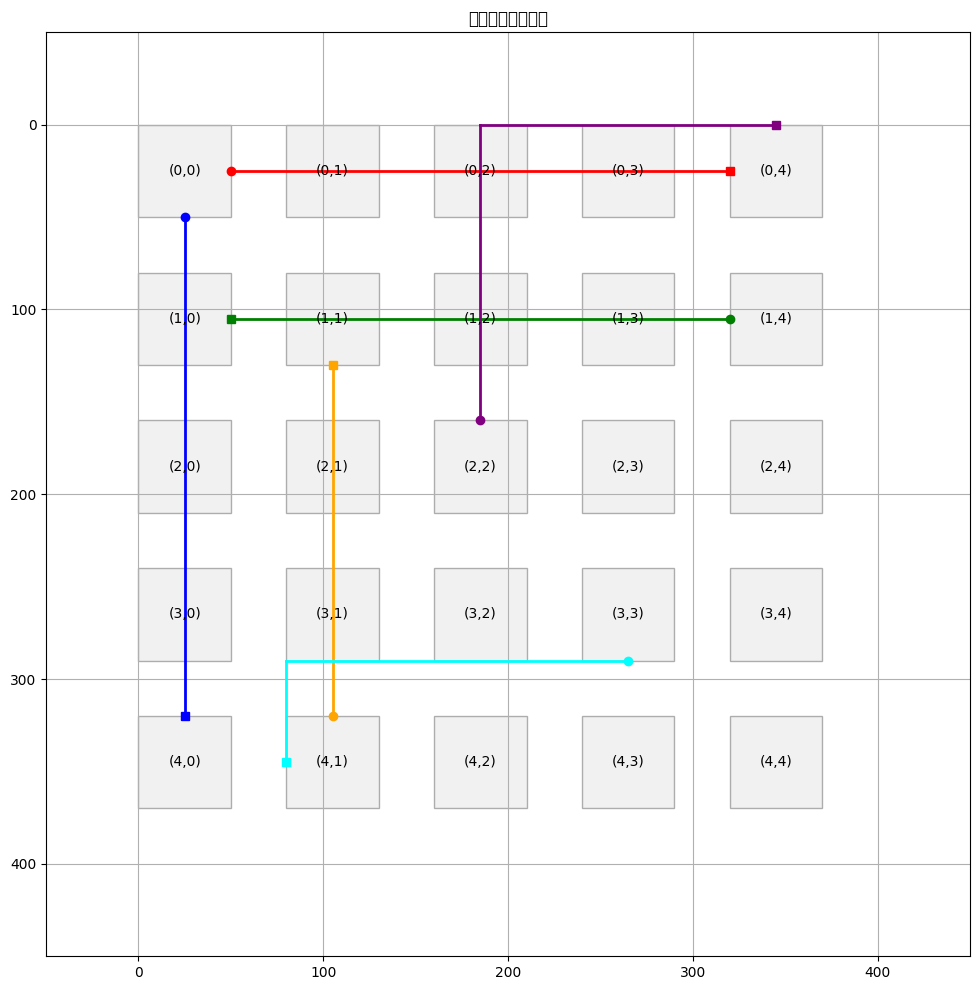

连线 1: 从单元格(0,0)到单元格(0,4)
  连线点坐标: [(50, 25), (320, 25)]

连线 2: 从单元格(1,4)到单元格(1,0)
  连线点坐标: [(320, 105), (50, 105)]

连线 3: 从单元格(0,0)到单元格(4,0)
  连线点坐标: [(25, 50), (25, 320)]

连线 4: 从单元格(4,1)到单元格(1,1)
  连线点坐标: [(105, 320), (105, 130)]

连线 5: 从单元格(2,2)到单元格(0,4)
  连线点坐标: [(185, 160), (185, 0), (345, 0)]

连线 6: 从单元格(3,3)到单元格(4,1)
  连线点坐标: [(265, 290), (80, 290), (80, 345)]



In [16]:
# 运行测试
test_connections()

## 自定义连接测试

下面可以尝试自定义一些连接进行测试

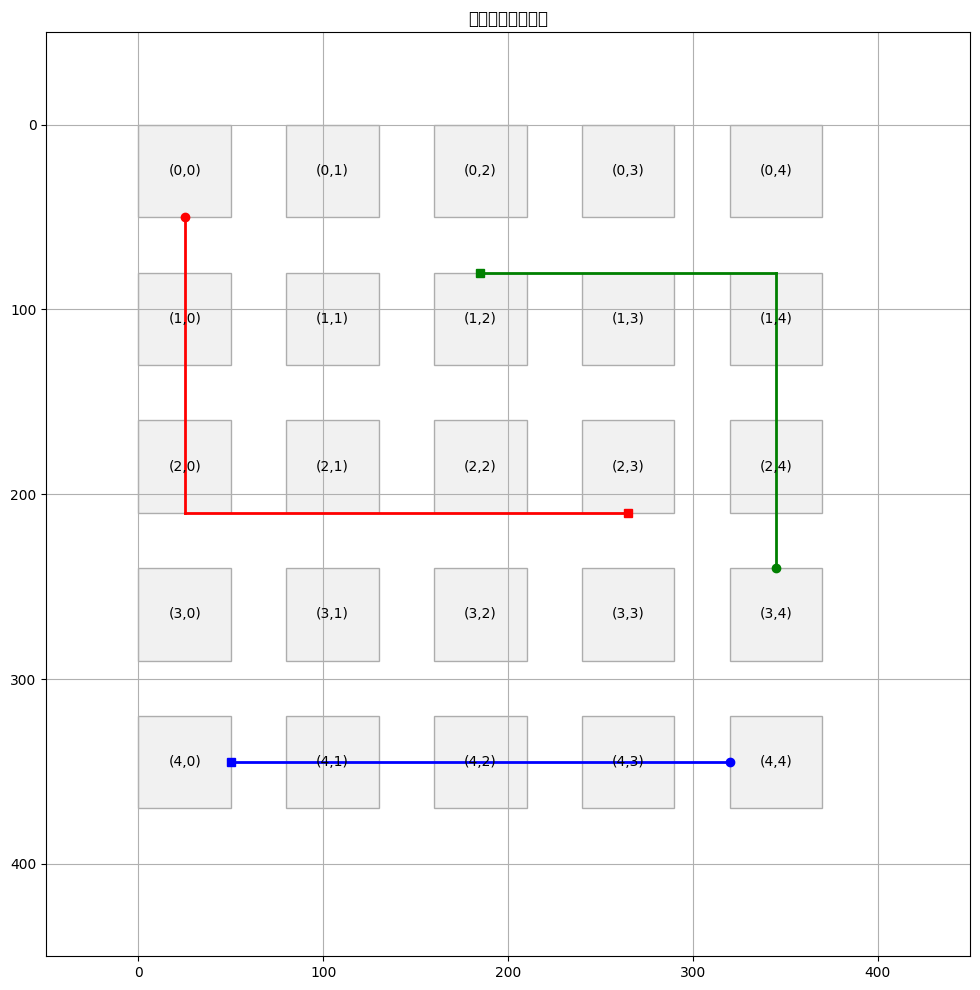

连线 1: 从单元格(0,0)到单元格(2,3)
  连线点坐标: [(25, 50), (25, 210), (265, 210)]

连线 2: 从单元格(3,4)到单元格(1,2)
  连线点坐标: [(345, 240), (345, 80), (185, 80)]

连线 3: 从单元格(4,4)到单元格(4,0)
  连线点坐标: [(320, 345), (50, 345)]



In [17]:
# 自定义连接测试
custom_connections = [
    {"start": [0, 0], "end": [2, 3]},
    {"start": [3, 4], "end": [1, 2]},
    {"start": [4, 4], "end": [4, 0]},
]

visualize_grid_and_connections(5, 5, custom_connections)
print_connection_details(custom_connections)

In [18]:
# 添加复杂测试案例
def test_complex_connections():
    """测试更复杂的连接情况，验证不穿越无关矩形的功能"""
    rows, cols = 6, 6
    connections = [
        {"start": [1, 1], "end": [4, 4]},  # 需要绕过中间的单元格
        {"start": [0, 0], "end": [5, 5]},  # 对角线连接
        {"start": [2, 0], "end": [2, 5]},  # 横穿一行
        {"start": [0, 3], "end": [5, 3]},  # 横穿一列
        {"start": [3, 1], "end": [1, 5]},  # 复杂路径
    ]
    
    visualize_grid_and_connections(rows, cols, connections)
    print_connection_details(connections)

In [19]:
# 添加测试重叠连线的函数
def test_overlapping_connections():
    """测试重叠连线情况下的处理"""
    rows, cols = 5, 5
    connections = [
        {"start": [0, 0], "end": [4, 4]},  # 对角线连接
        {"start": [0, 4], "end": [4, 0]},  # 交叉对角线连接
        {"start": [2, 0], "end": [2, 4]},  # 水平连接
        {"start": [0, 2], "end": [4, 2]},  # 垂直连接
        {"start": [1, 1], "end": [3, 3]},  # 另一个对角线连接
    ]
    
    visualize_grid_and_connections(rows, cols, connections)
    print_connection_details(connections)